In [1]:
import yt
from yt.units import *
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper
from yt.visualization.volume_rendering.transfer_functions import ProjectionTransferFunction, MultiVariateTransferFunction
from foggie.utils.get_refine_box import *
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.consistency import density_color_map, temperature_color_map, metal_color_map
from astropy.table import Table
import seaborn as sns
from collections import defaultdict

/Users/acharyya/Work/astro/ayan_codes/yt/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /Users/acharyya/.config/yt/ytrc is deprecated in favor of /Users/acharyya/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0.This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [2]:
foggie_dir = '/Volumes/Elements/foggieforayan' # '/Users/acharyya/models/simulation_output/foggie'
halo = '8508' # '5036'
output = 'RD0030' # 'RD0038'
do = 'density' # 'metal'
fullbox = False # True ; set to True to access the full refine box
galrad = 20. # radius of small box to extract, in kpc; ignored if fullbox = True
proj = 'x' # used to decide the initial camera position; choose from x, y, z OR None

use_full_colormap = True
plot_tf_self = False
plot_tf_temp = False
plot_tf_gas = False

In [3]:
ds = yt.load(foggie_dir + '/halo_00' + halo + '/nref11c_nref9f/' + output + '/' + output)

yt : [INFO     ] 2021-07-21 20:44:58,753 Parameters: current_time              = 342.59335094489
yt : [INFO     ] 2021-07-21 20:44:58,754 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-07-21 20:44:58,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-07-21 20:44:58,756 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-07-21 20:44:58,756 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-07-21 20:44:58,757 Parameters: current_redshift          = 0.69999998985822
yt : [INFO     ] 2021-07-21 20:44:58,757 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2021-07-21 20:44:58,758 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2021-07-21 20:44:58,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2021-07-21 20:44:58,759 Parameters: hubble_constant           = 0.695


In [4]:
def get_small_box(ds, center, box_width):
    '''
    Function to extract a box of given dimensions relative to a given center
    '''
    box_width_kpc = YTArray(box_width, 'kpc')
    small_box = ds.r[center[0] - box_width_kpc / 2.: center[0] + box_width_kpc / 2., center[1] - box_width_kpc / 2.: center[1] + box_width_kpc / 2., center[2] - box_width_kpc / 2.: center[2] + box_width_kpc / 2., ]

    return small_box

In [5]:
fig_dir = '/Users/acharyya/Work/astro/foggie_outputs/plots_halo_00' + halo + '/nref11c_nref9f/figs/' + output + '/'
if fullbox:
    trackname = '/Users/acharyya/Work/astro/ayan_codes/foggie/foggie/halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9'
    track = Table.read(trackname, format='ascii')
    track.sort('col1')
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')
    box, box_center, box_width = get_refine_box(ds, zsnap, track)
    box_width = box_width * get_proper_box_size(ds) # in kpc
else:
    halo_c_v_name = '/Users/acharyya/Work/astro/ayan_codes/foggie/foggie/halo_infos/00' + halo + '/nref11c_nref9f/halo_c_v'
    halo_c_v = Table.read(halo_c_v_name, format='ascii')
    halo_ind = np.where(halo_c_v['col3']==output)[0][0]
    box_center = ds.arr([float(halo_c_v['col4'][halo_ind]), float(halo_c_v['col5'][halo_ind]), float(halo_c_v['col6'][halo_ind])], 'kpc')
    box_width = galrad * 2 # in kpc
    box = get_small_box(ds, box_center, box_width)

Parsing Hierarchy : 100%|█████████▉| 5803/5804 [00:00<00:00, 9304.48it/s] 
yt : [INFO     ] 2021-07-21 20:45:05,302 Gathering a field list (this may take a moment.)


In [6]:
metal_color_map = sns.blend_palette(("#4575b4", "#984ea3", "#984ea3", "#d73027", "darkorange", "#ffe34d"), as_cmap=True)

# Set the bounds of the transfer function
bounds_dict = {'density':(1e-29, 1e-22), 'temp':(1e3,1e7), 'metal':((1e-2,1e1))}
#bounds_cgh = (ds.quan(bounds[0], 'g/cm**3'), ds.quan(bounds[1], 'g/cm**3'))
colormap_dict = {'tem':temperature_color_map, 'metal':'viridis', 'density':'viridis'}# 'cividis' # density_color_map # 
field_dict = {'density':('gas', 'density'), 'density_entropy':('gas', 'entropy'), 'stars':('deposit', 'stars_density'),'ys_density':('deposit', 'young_stars_density'), 'ys_age':('my_young_stars', 'age'), 'ys_mass':('deposit', 'young_stars_mass'), 'metal':('gas', 'metallicity'), 'temp':('gas', 'temperature'), 'dm':('deposit', 'dm_density'), 'vrad':('gas', 'radial_velocity_corrected'), 'vlos':('gas', 'v_corrected')}
weight_field_dict = defaultdict(lambda: None, metal=('density', 'density'), temp=('density', 'density'), vrad=('density', 'density'), vlos=('density', 'density'))
nlayers_dict = defaultdict(lambda: 8, density=8, temp=6, metal=5)
cam_pos_dict = defaultdict(lambda: box.left_edge.value, x=[1,0.5,0.5], y=[0.5,1,0.5], z=[0.5,0.5,1])
north_vector_dict = defaultdict(lambda: [0.8, -0.4, -0.4], x=[0,0,1], y=[1,0,0], z=[0,1,0])

field = field_dict[do]
weight_field = weight_field_dict[do]
colormap = colormap_dict[do]
bounds = bounds_dict[do]
starting_pos = ds.arr(cam_pos_dict[proj], 'code_length')

In [7]:
sc = yt.create_scene(box, field=field)

In [8]:
def linramp(vals, minval, maxval):
    return (vals - minval)/(maxval - minval)

In [9]:
def get_metal_color_function(tfh, bounds, colormap, nlayers=8, use_full_colormap=False):
    '''
    Function to make color transfer function for metallicity
    '''
    if use_full_colormap:
        tfh.tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap=colormap, scale_func=linramp)
    else:
        tfh.tf.add_layers(nlayers, w=0.01, alpha=np.logspace(-2.0, 0, nlayers), colormap=colormap)

    return tfh

In [10]:
def get_temp_color_function(tfh, bounds, colormap, nlayers=8, use_full_colormap=False):
    '''
    Function to make color transfer function for temperature
    '''
    if use_full_colormap:
        tfh.tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap=colormap, scale_func=linramp)
    else:
        tfh.tf.add_layers(nlayers, w=0.005, alpha=np.logspace(0, -2.5, nlayers), colormap=colormap)

    return tfh

In [29]:
def get_density_color_function(tfh, bounds, colormap, nlayers=8, use_full_colormap=False):
    '''
    Function to make color transfer function for density
    '''
    # the values below are hard-coded, corresponding to the gas density field range in Blizzard RD0038
    col_max, more_gauss1, more_gauss2 = 3e-24, 1e-23, 3e-23
    if use_full_colormap:
        tfh.tf.map_to_colormap(np.log10(bounds[0]), np.log10(bounds[1]), colormap=colormap, scale_func=linramp)
    else:
        # add_layers() function will add evenly spaced isocontours along the transfer function, sampling a colormap to determine the colors of the layers
        tfh.tf.add_layers(nlayers, w=0.01, alpha=np.logspace(-1.5, 0, nlayers), colormap=colormap, ma=np.log10(col_max), mi=np.log10(bounds[0]), col_bounds=[np.log10(bounds[0]), np.log10(col_max)])

        # if you would like to add a gaussian with a customized color or no color, use add_gaussian()
        tfh.tf.add_gaussian(np.log10(more_gauss1), width=.005, height=[1, 0.35, 0.0, 2.0])  # height = [R,G,B,alpha]
        tfh.tf.add_gaussian(np.log10(more_gauss2), width=.005, height=[1, 1, 0.8, 5.0])  # height = [R,G,B,alpha]

    return tfh

In [30]:
# think of color transfer functions as contours in 3D that are NOT NECESSARILY evenly spaced
tfh = TransferFunctionHelper(box.ds)
tfh.set_field(field)
tfh.set_bounds(bounds)
tfh.set_log(True)
tfh.build_transfer_function()
tfh.grey_opacity = True

color_func_dict = {'density': get_density_color_function, 'temp': get_temp_color_function, 'metal': get_metal_color_function}

tfh = color_func_dict[do](tfh, bounds, colormap, nlayers=nlayers_dict[do], use_full_colormap=use_full_colormap)

In [13]:
if plot_tf_self: tfh.plot(profile_field=field, profile_weight=weight_field)

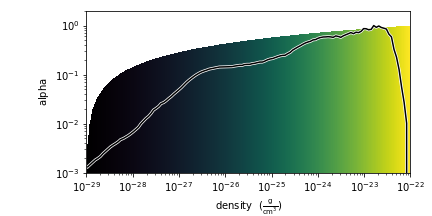

In [31]:
#tfh.plot(profile_field=field, profile_weight=weight_field)

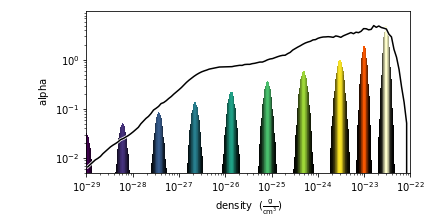

In [26]:
#tfh.plot(profile_field=field, profile_weight=weight_field)

In [14]:
if plot_tf_temp:  tfh.plot(profile_field='temperature')

In [15]:
if plot_tf_gas: tfh.plot(profile_field=('gas', 'density'))

In [16]:
cam = sc.add_camera(box, lens_type='perspective')
print('Default', cam)
cam.resolution = (128, 128) # (512, 512) # (256, 256) # 
cam.set_position(starting_pos)
cam.focus = box.center
cam.north_vector = north_vector_dict[proj]
displacement = (cam.focus - starting_pos).in_units('kpc').value # pointing from camera position to camera focus; basically should be equal to camera's normal vector
distance = np.linalg.norm(displacement) # magnitude of the displacement vector; in kpc
cam.set_width(ds.arr([box_width, box_width, distance], 'kpc'))
cam.switch_view()
print('New', cam)

Default <Camera Object>:
	position:[1. 1. 1.] code_length
	focus:[0.5 0.5 0.5] code_length
	north_vector:[ 0.81649658 -0.40824829 -0.40824829]
	width:[1.5 1.5 1.5] code_length
	light:None
	resolution:(512, 512)
Lens: <Lens Object>:
	lens_type:perspective
	viewpoint:[0.0669873 0.0669873 0.0669873] code_length code_length
New <Camera Object>:
	position:[1.  0.5 0.5] unitary
	focus:[0.49188137 0.48012066 0.5056963 ] unitary
	north_vector:[1.11927292e-02 4.37897901e-04 9.99937264e-01] dimensionless
	width:[4.72599997e-04 4.72599997e-04 5.08539259e-01] unitary
	light:None
	resolution:(128, 128)
Lens: <Lens Object>:
	lens_type:perspective
	viewpoint:[0.23782206 0.47018099 0.50854445] unitary unitary


In [17]:
print('\ncam normal vector=', cam.normal_vector)
print('displacement vector kpc=', displacement)
print('displacement vector hat=', displacement/distance)
print('\ncam_width_kpc=', ds.arr(cam.get_width() * get_proper_box_size(ds), 'kpc'))
print('box_width_kpc=', box_width, '; distance_kpc=', distance)
print('box_width_code=', box_width / get_proper_box_size(ds), '; distance_code=', distance / get_proper_box_size(ds))
print('\nbox_center_code=', box_center.in_units('code_length'))
print('box.center_code=', box.center.in_units('code_length'))
print('box.center_cm=', box.center.in_units('cm'))
print('box.left_edge_cm=', box.left_edge.in_units('cm'))
print('box.right_edge_cm=', box.right_edge.in_units('cm'))
print('box.width_cm=', box.right_edge.in_units('cm') - box.left_edge.in_units('cm'))
print('box.width_kpc=', box.right_edge.in_units('kpc') - box.left_edge.in_units('kpc'))


cam normal vector= [-0.99917287 -0.03909106  0.01120129] dimensionless
displacement vector kpc= [-43006.23211908  -1682.5510998     482.124141  ]
displacement vector hat= [-0.99917287 -0.03909106  0.01120129]

cam_width_kpc= [4.00000000e+01 4.00000000e+01 4.30418334e+04] kpc
box_width_kpc= 40.0 ; distance_kpc= 43041.83340624042
box_width_code= 0.0004725999971805851 ; distance_code= 0.5085392586609109

box_center_code= [0.49188137 0.48012066 0.5056963 ] code_length
box.center_code= [0.49188137 0.48012066 0.5056963 ] code_length
box.center_cm= [1.28462745e+26 1.25391245e+26 1.32070735e+26] cm
box.left_edge_cm= [1.28401031e+26 1.25329532e+26 1.32009022e+26] cm
box.right_edge_cm= [1.28524458e+26 1.25452959e+26 1.32132449e+26] cm
box.width_cm= [1.23427103e+23 1.23427103e+23 1.23427103e+23] cm
box.width_kpc= [40. 40. 40.] kpc


In [18]:
#ptf = ProjectionTransferFunction()
#ptf.add_field_table(tfh.tf, 0)

In [19]:
source = sc.get_source()
#source.set_weight_field(weight_field)
source.set_transfer_function(tfh.tf)

<Volume Source>:YTRegion (RD0030): , center=[1.28462745e+26 1.25391245e+26 1.32070735e+26] cm cm, left_edge=[1.28401031e+26 1.25329532e+26 1.32009022e+26] cm cm, right_edge=[1.28524458e+26 1.25452959e+26 1.32132449e+26] cm cm transfer_function:<Color Transfer Function Object>:
x_bounds:[-29, -22] nbins:512 features:
	('map_to_colormap', 'start(x):-29', 'stop(x):-24', 'value(y):  1')

yt : [INFO     ] 2021-07-15 17:26:36,083 Rendering scene (Can take a while).
yt : [INFO     ] 2021-07-15 17:26:36,084 Creating volume
/Users/acharyya/opt/anaconda3/envs/astroconda/lib/python3.6/site-packages/unyt/array.py:1674: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


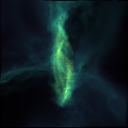

In [20]:
im = sc.render()
sc.show(sigma_clip=8)

yt : [INFO     ] 2021-07-15 17:26:42,430 Rendering scene (Can take a while).


New <Camera Object>:
	position:[1.  0.5 0.5] unitary
	focus:[0.49188137 0.48012066 0.5056963 ] unitary
	north_vector:[1.11927292e-02 4.37897901e-04 9.99937264e-01] dimensionless
	width:[3.54449998e-04 3.54449998e-04 5.08044997e-01] unitary
	light:None
	resolution:(128, 128)
Lens: <Lens Object>:
	lens_type:perspective
	viewpoint:[0.23806898 0.47019065 0.50854168] unitary unitary


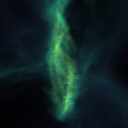

In [21]:
cam.set_width(ds.arr([30., 30., 4.3e4], 'kpc'))
print('New', cam)

im = sc.render()
sc.show(sigma_clip=8)

New <Camera Object>:
	position:[0.98882852 0.58793186 0.5       ] unitary
	focus:[0.49188137 0.48012066 0.5056963 ] unitary
	north_vector:[0.01094038 0.00240372 0.99993726] dimensionless
	width:[3.54449998e-04 3.54449998e-04 5.08044997e-01] unitary
	light:None
	resolution:(128, 128)
Lens: <Lens Object>:
	lens_type:perspective
	viewpoint:[0.24364929 0.42626745 0.50854168] unitary unitary


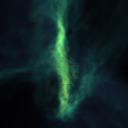

In [22]:
cam.rotate(np.pi/18.0, rot_vector=north_vector_dict[proj], rot_center=ds.arr(cam.focus))
cam.switch_orientation()
print('New', cam)

im = sc.render()
sc.show(sigma_clip=8)

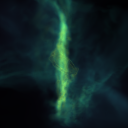

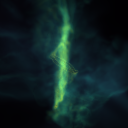

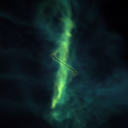

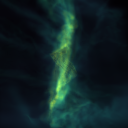

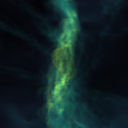

In [23]:
for i in cam.iter_rotate(np.pi/2, 5, rot_vector=[0,1,0], rot_center=ds.arr(cam.focus)):
    im = sc.render()
    sc.show(sigma_clip=8)
    #sc.save(fig_dir + do + '_box' + str(box_width) + 'kpc_proj_' + proj + '_trial_rotation_%04i.png' % i, sigma_clip=8, render=False)